# TOPIX の分布

In [3]:
import pandas as pd
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')
import yfinance as yf

In [4]:
# TOPIXの価格データを取得
topix = yf.download('^TOPX', start='2014-11-29', end='2024-11-29')
topix['log_adj_close'] = np.log(topix['Adj Close'])
topix['log_adj_close_diff'] = topix['log_adj_close'].diff()
# データの先頭を表示
topix.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,log_adj_close,log_adj_close_diff
Ticker,^TOPX,^TOPX,^TOPX,^TOPX,^TOPX,^TOPX,,
Date,,,,,,,,
2014-12-01,1421.650024,1421.650024,1427.119995,1413.599976,1413.599976,202400,7.259573,NaN
2014-12-02,1427.849976,1427.849976,1429.489990,1414.000000,1414.000000,201400,7.263925,0.004352
2014-12-03,1429.750000,1429.750000,1440.670044,1427.229980,1435.979980,251900,7.265255,0.001330
2014-12-04,1440.599976,1440.599976,1443.329956,1437.040039,1441.459961,223900,7.272815,0.007560
2014-12-05,1445.670044,1445.670044,1445.770020,1433.880005,1438.900024,207000,7.276328,0.003513


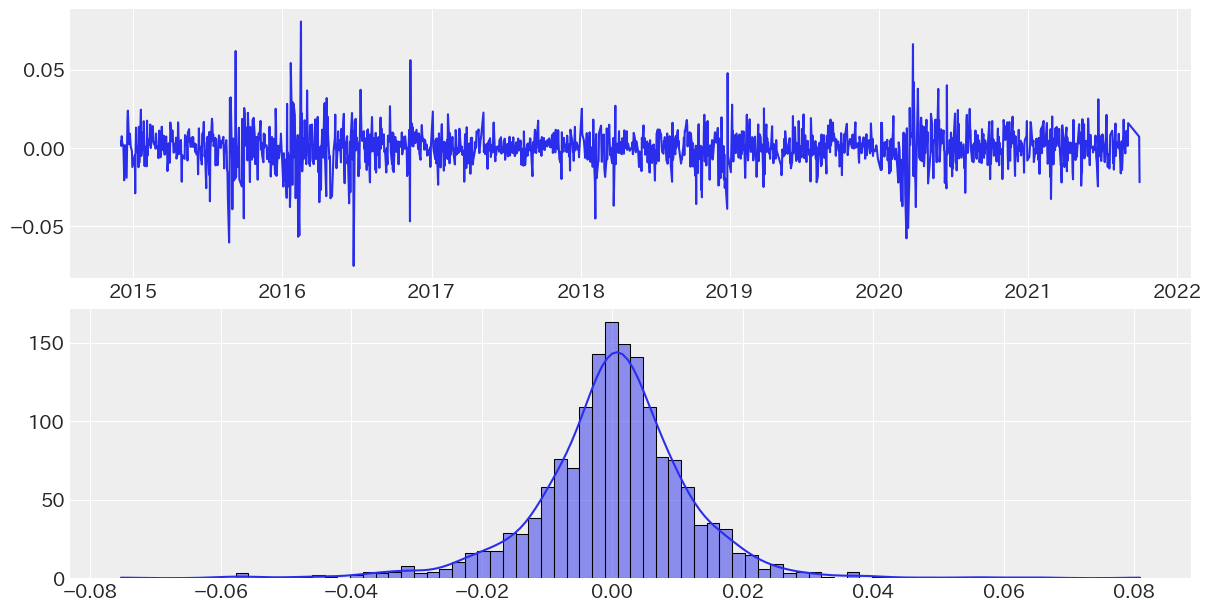

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(211)
sns.lineplot(x=topix.index, y='log_adj_close_diff', data=topix)
plt.ylabel('')
plt.xlabel('')

plt.subplot(212)
sns.histplot(topix['log_adj_close_diff'], kde=True)
plt.ylabel('')
plt.xlabel('')

plt.show()

## 正規分布

### modeling

In [ ]:
with pm.Model() as topix_normal:
    # data
    y = pm.Data('y', topix['log_adj_close_diff'].dropna())

    # prior
    mu = pm.Normal('mu', mu=0, sigma=0.01)
    sigma = pm.HalfNormal('sigma', sigma=0.01)

    # likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # sampling
    trace_normal = pm.sample(
        draws=1500,
        tune=1000,
        chains=4,
        nuts_sampler='numpyro'
    )

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [16]:
with topix_normal:
    pm.sample_posterior_predictive(trace_normal, extend_inferencedata=True)

Sampling: [y_obs]


Output()

### results

In [17]:
az.summary(trace_normal)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.000,0.0,-0.000,0.001,0.0,0.0,5986.0,4285.0,1.0
sigma,0.012,0.0,0.012,0.013,0.0,0.0,1032.0,1016.0,1.0


In [74]:
annualized_return = trace_normal.posterior_predictive['y_obs'].values.flatten().mean() * 365.25
annualized_volatility = trace_normal.posterior_predictive['y_obs'].values.flatten().std() * np.sqrt(365.25)
print(f'年率リターン: {annualized_return:.2%}')
print(f'年率ボラティリティ: {annualized_volatility:.2%}')

年率リターン: 7.47%
年率ボラティリティ: 23.26%


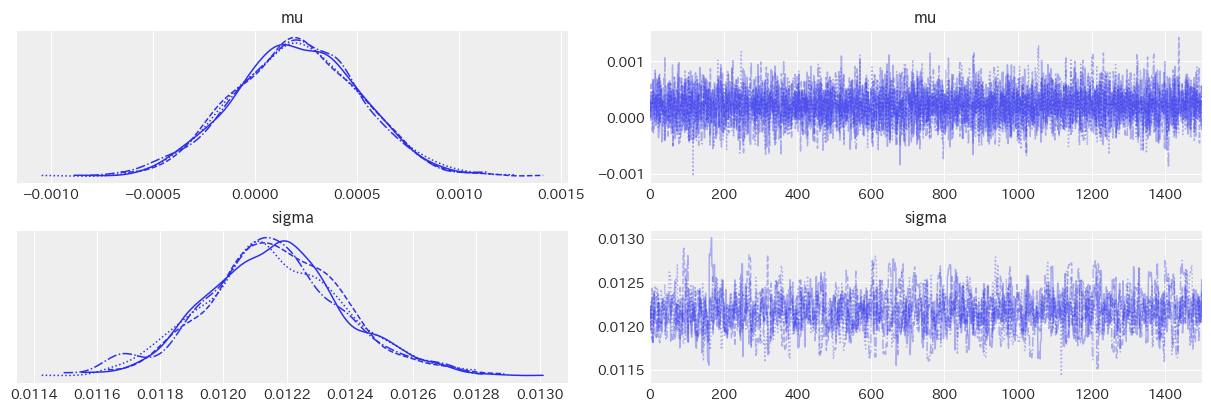

In [18]:
az.plot_trace(trace_normal);

<Figure size 1200x600 with 0 Axes>

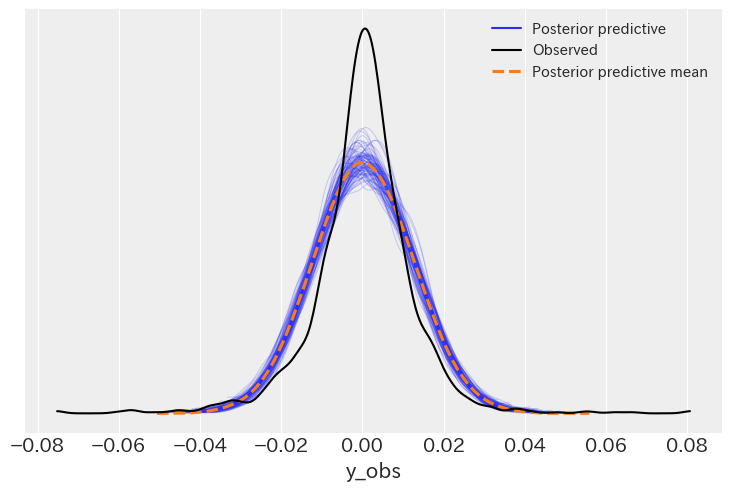

In [19]:
plt.figure(figsize=(12, 6))
az.plot_ppc(trace_normal, num_pp_samples=100)
plt.show()

## t 分布

### modeling

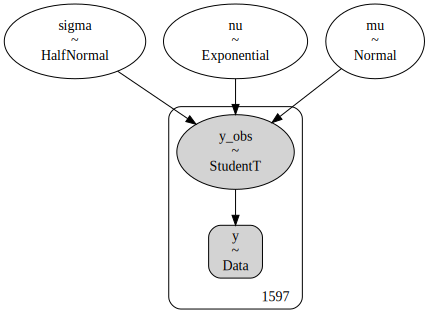

In [21]:
with pm.Model() as topix_t:
    # data
    y = pm.Data('y', topix['log_adj_close_diff'].dropna())

    # prior
    nu = pm.Exponential('nu', lam=1/30)
    mu = pm.Normal('mu', mu=0, sigma=0.01)
    sigma = pm.HalfNormal('sigma', sigma=0.01)

    # likelihood
    y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma, nu=nu, observed=y)

pm.model_to_graphviz(topix_t)

In [ ]:

    # sampling
    trace_t = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        nuts_sampler='numpyro'
    )

In [6]:
with topix_t:
    pm.sample_posterior_predictive(trace_t, extend_inferencedata=True)

Sampling: [y_obs]


Output()

### results

In [9]:
az.summary(trace_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.001,0.000,0.000,0.001,0.000,0.000,4785.0,3304.0,1.0
nu,3.118,0.278,2.603,3.641,0.009,0.006,1024.0,1110.0,1.0
sigma,0.008,0.000,0.007,0.008,0.000,0.000,979.0,1154.0,1.0


In [8]:
annualized_return = trace_t.posterior_predictive['y_obs'].values.flatten().mean() * 365.25
annualized_volatility = trace_t.posterior_predictive['y_obs'].values.flatten().std() * np.sqrt(365.25)
print(f'年率リターン: {annualized_return:.2%}')
print(f'年率ボラティリティ: {annualized_volatility:.2%}')

年率リターン: 22.33%
年率ボラティリティ: 25.50%


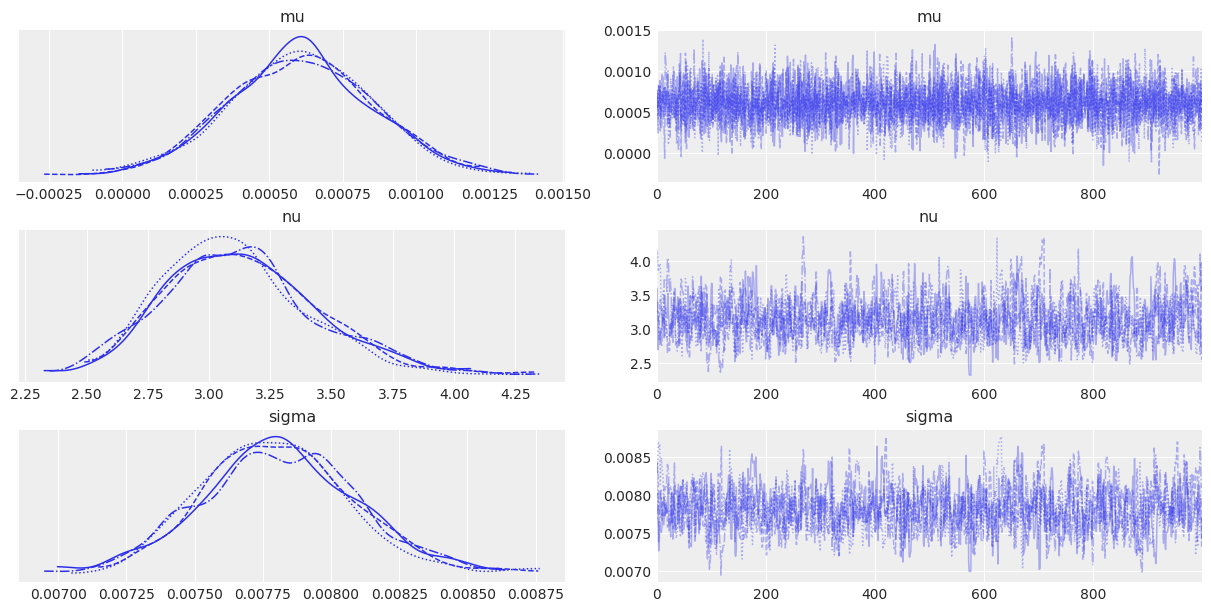

In [35]:
az.plot_trace(trace_t);

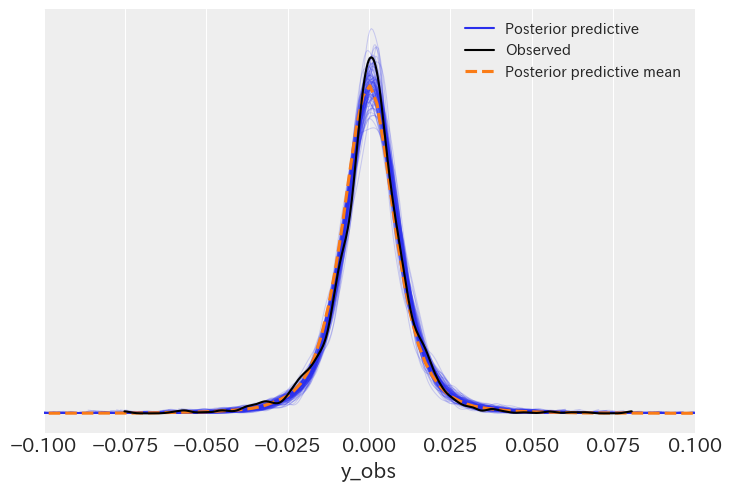

In [20]:
az.plot_ppc(trace_t, num_pp_samples=100)
plt.xlim(-0.1, 0.1)
plt.show()